In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [96]:
from alinemol.preprocessing import standardize_smiles, drop_duplicates
from alinemol.utils.split_utils import get_scaffold

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)

%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
mol_df = pd.read_csv("tests/conftest/dili.csv")

In [4]:
mol_df = standardize_smiles(mol_df)

In [5]:
mol_df[mol_df['canonical_smiles'].duplicated()]

,label,smiles,canonical_smiles,molecular_weight,num_atoms


In [6]:
X = np.array(mol_df["smiles"])
y = np.array(mol_df["label"])

In [12]:
scaf = [get_scaffold(smi) for smi in X]

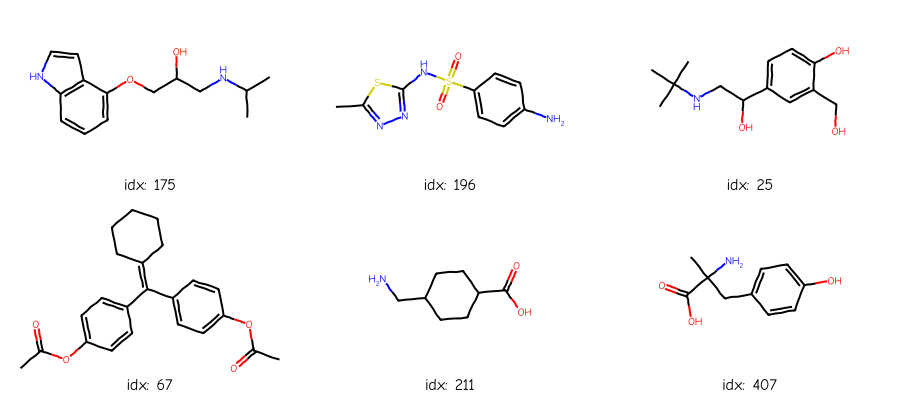

In [36]:
## chosse 6 random structure and corresponding scaffold
np.random.seed(7)
idx = np.random.choice(len(X), 6)
mols = [Chem.MolFromSmiles(X[i]) for i in idx]
scafs = [Chem.MolFromSmiles(scaf[i]) for i in idx]

## draw the molecules and their scaffolds
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img

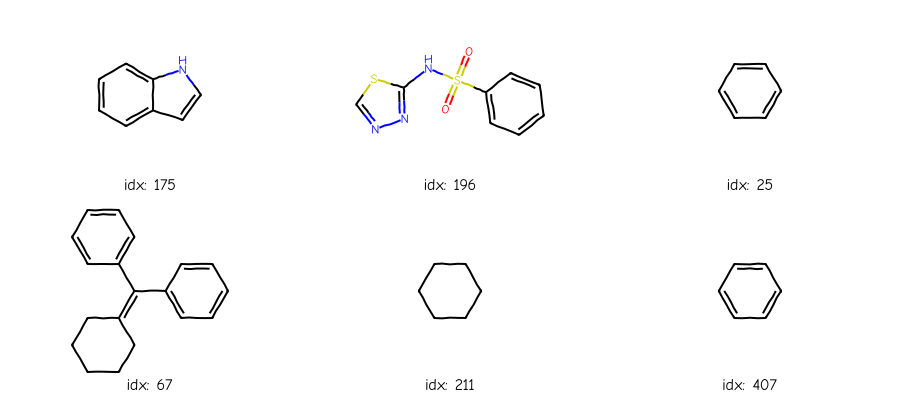

In [37]:
# Draw scaffold
img_scaf = Draw.MolsToGridImage(scafs, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img_scaf

In [6]:
dataset_category="MoleculeNet"
dataset_names="HIV"
dataset = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_simplified" + ".csv"))

In [7]:
dataset

,smiles,label
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,0


In [21]:
dataset['smiles'].duplicated().sum()

0

In [8]:
new_df = standardize_smiles(dataset)

[2024-05-27 15:29:23,529:Standardizer:CRITICAL] charge_parent FAILED: Explicit valence for atom # 1 H, 3, is greater than permitted
[2024-05-27 15:32:37,207:Standardizer:CRITICAL] charge_parent FAILED: Explicit valence for atom # 5 Ge, 6, is greater than permitted


In [10]:
new_df

,smiles,label,canonical_smiles,molecular_weight,num_atoms
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,319.888,19.0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,564.140,39.0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,291.375,21.0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,370.408,24.0
4,O=S(=O)(O)CCS(=O)(=O)O,0,O=S(=O)(O)CCS(=O)(=O)O,190.198,10.0
...,...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,0,Cc1ccc(-n2c(O)c3c(c2O)C2CC(C(C)(C)C)CCC2c2c-3[...,440.587,33.0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,0,Cc1cccc(-n2c(O)c3c(c2O)C2CC(C(C)(C)C)CCC2c2c-3...,440.587,33.0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,0,CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...,543.451,37.0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,0,NaN,NaN,NaN


In [11]:
new_df['canonical_smiles'].isna().sum()

2

In [12]:
new_df = new_df.dropna(subset=['canonical_smiles'])
new_df = new_df[["canonical_smiles", "label"]]
new_df.columns = ["smiles", "label"]

In [14]:
new_df.to_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_processed" + ".csv"), index=False)

In [22]:
new_df[new_df['smiles'].duplicated()]

,smiles,label
339,CC(=O)C[PH](c1ccccc1)(c1ccccc1)c1ccccc1,0
341,O=C(C[PH](c1ccccc1)(c1ccccc1)c1ccccc1)c1ccccc1,0
1096,O=c1c2ccccc2oc2ccccc12,0
1549,CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,0
1991,COC1C(OC(=O)C=CC=CC=CC=CC(=O)O)CCC2(CO2)C1C1(C...,0
...,...,...
40353,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,0
40478,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,1
40627,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCCC(c5cc(Cl)c(O)c(...,0
40956,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,0


In [32]:
dff = new_df[new_df.groupby('smiles').label.transform('nunique') == 1]

In [40]:
dff=dff.drop_duplicates(subset=['smiles'], keep='first')

In [42]:
dff.reset_index(drop=True, inplace=True)

In [44]:
dff.label.value_counts()

label
0    39488
1     1415
Name: count, dtype: int64

In [28]:
new_df.groupby('smiles').label.nunique()>1

smiles
BC(=O)NC(CC(C)C)C(=O)NC1C(=O)C(O)c2sccc21                                    False
BC(=O)NC(CC(C)C)C(=O)NCC(=O)NC1C(=O)C(O)c2sccc21                             False
BrC(=C(c1ccc(OC2CCCCO2)cc1)c1ccc(OC2CCCCO2)cc1)c1ccccc1                      False
BrC(Br)([P+](c1ccccc1)(c1ccccc1)c1ccccc1)[P+](c1ccccc1)(c1ccccc1)c1ccccc1    False
BrC(Br)=C1C(=C(Br)Br)C(Br)C1Br                                               False
                                                                             ...  
c1scc2c1COCCOCCOCCOCCOCCOCCOC2                                               False
c1scc2c1COCCOCCOCCOCc1cscc1COCCOCCOCCOC2                                     False
c1snnc1-c1cnns1                                                              False
n1[nH]nc2c1c1n[nH]nc1c1n[nH]nc21                                             False
n1onc2c1NC1Nc3nonc3NC1N2                                                     False
Name: label, Length: 40924, dtype: bool

In [31]:
new_df.groupby('smiles').label.transform('nunique')

0        1
1        1
2        1
3        1
4        1
        ..
41120    1
41121    1
41122    1
41123    1
41124    1
Name: label, Length: 41125, dtype: int64

In [3]:
x  = ['CC', 'CC', 'CC', 'CCC', 'CCC', 'CCCC', 'CCCCC', 'CCCCC']
label= [1, 1, 0, 1, 1, 1, 1, 0]
df = pd.DataFrame({'smiles': x, 'label': label})
df = standardize_smiles(df)

In [7]:
df = df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

NameError: name 'df' is not defined

In [10]:
drop_duplicates(df)['label'].nunique()

1

In [7]:
mol_df = mol_df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [8]:
import splito
from splito import *

In [14]:
def splits_scaffold(test_dataset_dili, make_generic):
    smiles = test_dataset_dili["smiles"].values
    splitter = ScaffoldSplit(smiles, n_splits=5, make_generic=make_generic, test_size=None)
    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_scfs = set([get_scaffold(smiles[i], make_generic=make_generic) for i in train_ind])
        print(len(train_scfs))
        test_scfs = [get_scaffold(smiles[i], make_generic=make_generic) for i in test_ind]
        print(len(test_scfs))
        print(len(set(test_scfs)))
        print(test_scfs[0])
        assert not any(test_scf in train_scfs for test_scf in test_scfs)

In [15]:
splits_scaffold(mol_df, make_generic=False)

392
82
248
82
63
c1cnccn1
303
171
248
171
63

389
85
248
85
63
C1CCCCC1
317
157
248
157
63

367
107
248
107
63



In [63]:
import datamol as dm

In [76]:
def splits_molecular_weight(test_dataset_dili, generalize_to_larger):
    smiles = test_dataset_dili["smiles"].values
    splitter = MolecularWeightSplit(generalize_to_larger=generalize_to_larger, n_splits=2, test_size=0.1)

    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > len(test_ind)
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_mws = [dm.descriptors.mw(dm.to_mol(smi)) for smi in smiles[train_ind]]
        if generalize_to_larger:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) >= max(train_mws) for smi in smiles[test_ind]
            )
        else:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) <= min(train_mws) for smi in smiles[test_ind]
            )

In [82]:
from splito import MaxDissimilaritySplit

In [9]:
def test_splits_max_dissimilar_default_feats(test_dataset_smiles):
    splitter = MaxDissimilaritySplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0

In [10]:
mol_df

,smiles,label
0,CC(=O)OCC[N+](C)(C)C,0.0
1,C[N+](C)(C)CC(=O)[O-],0.0
2,O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl,0.0
3,O=C(O)c1ccccc1O,0.0
4,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,0.0
...,...,...
469,CCCC(CCC)C(=O)O,1.0
470,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)O,0.0
471,C=C1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)...,1.0
472,OCC(O)c1oc(O)c(O)c1O,0.0


In [11]:
smiles = mol_df["smiles"].values

In [12]:
test_splits_max_dissimilar_default_feats(smiles)

2024-05-29 14:07:12.405 | DEBUG    | splito.utils:get_kmeans_clusters:68 - To use KMeans with the jaccard metric, we use the Empirical Kernel Map
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x72c73e51f880>
Traceback (most recent call last):
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = ge

In [87]:
from splito import PerimeterSplit


def test_splits_perimeter(test_dataset_smiles):
    splitter = PerimeterSplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        assert splitter._metric == "jaccard"

In [90]:
splitter = PerimeterSplit(n_splits=2)

In [91]:
splitter

PerimeterSplit(metric=None, n_clusters=None, n_jobs=None, n_splits=2,
        random_state=None, test_size=None, train_size=None)

In [89]:
splitter = PerimeterSplit(n_splits=2)

for train_ind, test_ind in splitter.split(smiles):
    assert len(train_ind) + len(test_ind) == len(smiles)
    assert len(set(train_ind).intersection(set(test_ind))) == 0
    assert len(train_ind) > 0 and len(test_ind) > 0
    assert splitter._metric == "jaccard"

2024-05-29 14:04:21.854 | DEBUG    | splito.utils:get_kmeans_clusters:68 - To use KMeans with the jaccard metric, we use the Empirical Kernel Map
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7d9a275dab90>
Traceback (most recent call last):
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = ge

In [77]:
splits_molecular_weight(mol_df, generalize_to_larger=True)

2024-05-29 13:56:39.787 | WARNING  | splito._molecular_weight:_iter_indices:66 - n_splits=2 > 1, but MolecularWeightSplit is deterministic and will always return the same split!


426
48
426
48


In [20]:
## aplly all the splitter that are available in splito on the moldf dataset and create train and test index
splitter = splito.MolecularWeightSplit(test_size=0.2, generalize_to_larger=True)
train_idx, test_idx = next(splitter.split(X=mol_df.smiles.tolist()))
assert train_idx.shape[0] > test_idx.shape[0]

2024-05-28 17:05:01.895 | WARNING  | splito._molecular_weight:_iter_indices:66 - n_splits=5 > 1, but MolecularWeightSplit is deterministic and will always return the same split!


In [22]:
mol_df.loc[train_idx, "MolecularWeightSplit"] = "train"
mol_df.loc[test_idx, "MolecularWeightSplit"] = "test"

In [23]:
import datamol as dm

In [24]:
mol_df["mw"] = mol_df.smiles.apply(lambda smi: dm.descriptors.mw(dm.to_mol(smi)))

MolecularWeightSplit
test     Axes(0.125,0.11;0.775x0.77)
train    Axes(0.125,0.11;0.775x0.77)
Name: mw, dtype: object

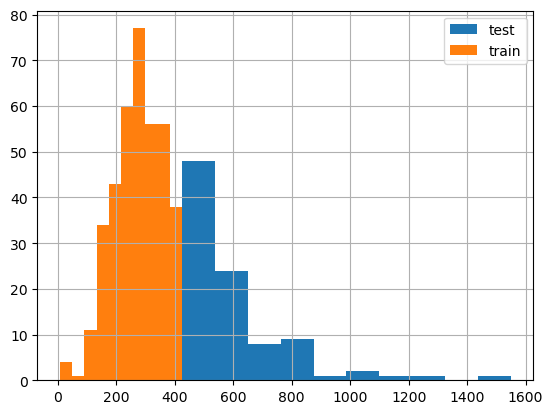

In [26]:
mol_df.groupby(by="MolecularWeightSplit")["mw"].hist(legend=True)

AttributeError: 'DataFrame' object has no attribute 'unique'

In [42]:
mol_df =mol_df[-mol_df.duplicated()]

In [43]:
from alinemol.utils.split_utils import get_scaffold
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold"] = get_scaffold(mol_df.loc[idx, "smiles"])

/tmp/ipykernel_4090333/1870540195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mol_df.loc[idx, "scaffold"] = get_scaffold(mol_df.loc[idx, "smiles"])


In [52]:
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold_generic"] = get_scaffold(mol_df.loc[idx, "smiles"], make_generic=True)

/tmp/ipykernel_4090333/3064777965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mol_df.loc[idx, "scaffold_generic"] = get_scaffold(mol_df.loc[idx, "smiles"], make_generic=True)


In [54]:
mol_df['scaffold_generic'].nunique()

263

In [83]:
dataset_category="MoleculeNet"
dataset_names="HIV"
split_type="scaffold"
filename="external_test_balanced.csv"
train_filename="train_balanced.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

In [84]:
external_test = pd.read_csv(os.path.join (SPLIT_PATH, split_type, filename))
train = pd.read_csv(os.path.join (SPLIT_PATH, split_type, train_filename))
df = pd.concat([external_test, train])

In [78]:
#df= pd.read_csv("datasets/TDC/CYP3A4/CYP3A4_simplified.csv")

In [85]:
train_scaf = [get_scaffold(smi) for smi in train["smiles"]]
external_test_scaf = [get_scaffold(smi) for smi in external_test["smiles"]]
df_scaf = [get_scaffold(smi) for smi in df["smiles"]]


In [97]:
pd.Series(df_scaf).value_counts(sort=False).plot(kind='bar')

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x7b04d0ea8160> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'O=C(Cc1ccccc1)OCC#CCOC(=O)Cc1ccccc1'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp7qfolq7r 992fcd6c09ed14f790bfb4e89d6204fc.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./992fcd6c09ed14f790bfb4e89d6204fc.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 992fcd6c09ed14f790bfb4e89d6204fc.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 {\rmfamily O=C(Cc1ccccc1)OCC#
                                  CCOC(=O)Cc1ccccc1}%
No pages of output.
Transcript written on tmp7qfolq7r/992fcd6c09ed14f790bfb4e89d6204fc.log.




RuntimeError: latex was not able to process the following string:
b'O=C(Cc1ccccc1)OCC#CCOC(=O)Cc1ccccc1'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpye96nweo 992fcd6c09ed14f790bfb4e89d6204fc.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./992fcd6c09ed14f790bfb4e89d6204fc.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 992fcd6c09ed14f790bfb4e89d6204fc.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 {\rmfamily O=C(Cc1ccccc1)OCC#
                                  CCOC(=O)Cc1ccccc1}%
No pages of output.
Transcript written on tmpye96nweo/992fcd6c09ed14f790bfb4e89d6204fc.log.




<Figure size 640x480 with 1 Axes>

In [ ]:
fis, ax=plt.subplots(1, 3, figsize=(15, 5))
pd.Series(train_scaf).value_counts(sort=False).plot(kind='bar', ax=ax[0])

In [86]:
df_scaf_uni = list(set(df_scaf))

In [93]:
#plot hist of df_scaf
from collections import Counter
#a=Counter(df_scaf)
#print(a)
import matplotlib.pyplot as plt
plt.hist(np.array(df_scaf), bins=10)
#plt.show()

(array([318., 320., 307., 300., 459., 348., 326., 355., 415., 295.]),
 array([   0. ,  232.3,  464.6,  696.9,  929.2, 1161.5, 1393.8, 1626.1,
        1858.4, 2090.7, 2323. ]),
 <BarContainer object of 10 artists>)

Error in callback <function _draw_all_if_interactive at 0x7b04d0ea8160> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'O=C(Cc1ccccc1)OCC#CCOC(=O)Cc1ccccc1'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp0ysf927x 992fcd6c09ed14f790bfb4e89d6204fc.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./992fcd6c09ed14f790bfb4e89d6204fc.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 992fcd6c09ed14f790bfb4e89d6204fc.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 {\rmfamily O=C(Cc1ccccc1)OCC#
                                  CCOC(=O)Cc1ccccc1}%
No pages of output.
Transcript written on tmp0ysf927x/992fcd6c09ed14f790bfb4e89d6204fc.log.




RuntimeError: latex was not able to process the following string:
b'O=C(Cc1ccccc1)OCC#CCOC(=O)Cc1ccccc1'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpkozyu_lr 992fcd6c09ed14f790bfb4e89d6204fc.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./992fcd6c09ed14f790bfb4e89d6204fc.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 992fcd6c09ed14f790bfb4e89d6204fc.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 {\rmfamily O=C(Cc1ccccc1)OCC#
                                  CCOC(=O)Cc1ccccc1}%
No pages of output.
Transcript written on tmpkozyu_lr/992fcd6c09ed14f790bfb4e89d6204fc.log.




<Figure size 640x480 with 1 Axes>

In [87]:
print(len(df_scaf_uni))
print(df.shape)
print(len(df_scaf_uni)/df.shape[0])

2324
(3443, 2)
0.6749927388905025


In [82]:
train_scaf_uni = list(set(train_scaf))
external_test_scaf_uni = list(set(external_test_scaf))

print(len(train_scaf_uni))
print(len(train_scaf_uni)/train.shape[0])
print(len(external_test_scaf_uni))
print(len(external_test_scaf_uni)/external_test.shape[0])

print(set(train_scaf_uni).intersection(set(external_test_scaf_uni)))

5181
0.6004171978213003
1661
0.6732873935954601
set()
